In [1]:
import pandas as pd
import numpy as np

import missingno as msno
import statsmodels.api as sm
from fbprophet import Prophet

import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from pylab import rcParams
rcParams['figure.figsize'] = 17, 14

from IPython.display import display

pd.options.display.float_format = '{:,.2f}'.format

pd.options.display.max_rows = 999

plt.rc('font', size=14)   

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df=pd.read_csv('housing_in_london_monthly_variables.csv')
df_1= pd.read_csv ('housing_in_london_yearly_variables.csv')
display(df.head(10))
display(df_1.head(10))

,date,area,average_price,code,houses_sold,no_of_crimes,borough_flag
0,1995-01-01,city of london,91449,E09000001,17.00,NaN,1
1,1995-02-01,city of london,82203,E09000001,7.00,NaN,1
2,1995-03-01,city of london,79121,E09000001,14.00,NaN,1
3,1995-04-01,city of london,77101,E09000001,7.00,NaN,1
4,1995-05-01,city of london,84409,E09000001,10.00,NaN,1
5,1995-06-01,city of london,94901,E09000001,17.00,NaN,1
6,1995-07-01,city of london,110128,E09000001,13.00,NaN,1
7,1995-08-01,city of london,112329,E09000001,14.00,NaN,1
8,1995-09-01,city of london,104473,E09000001,17.00,NaN,1
9,1995-10-01,city of london,108038,E09000001,14.00,NaN,1


,code,area,date,median_salary,life_satisfaction,mean_salary,recycling_pct,population_size,number_of_jobs,area_size,no_of_houses,borough_flag
0,E09000001,city of london,1999-12-01,"33,020.00",NaN,48922,0,"6,581.00",NaN,NaN,NaN,1
1,E09000002,barking and dagenham,1999-12-01,"21,480.00",NaN,23620,3,"162,444.00",NaN,NaN,NaN,1
2,E09000003,barnet,1999-12-01,"19,568.00",NaN,23128,8,"313,469.00",NaN,NaN,NaN,1
3,E09000004,bexley,1999-12-01,"18,621.00",NaN,21386,18,"217,458.00",NaN,NaN,NaN,1
4,E09000005,brent,1999-12-01,"18,532.00",NaN,20911,6,"260,317.00",NaN,NaN,NaN,1
5,E09000006,bromley,1999-12-01,"16,720.00",NaN,21293,13,"294,902.00",NaN,NaN,NaN,1
6,E09000007,camden,1999-12-01,"23,677.00",NaN,30249,13,"190,003.00",NaN,NaN,NaN,1
7,E09000008,croydon,1999-12-01,"19,563.00",NaN,22205,13,"332,066.00",NaN,NaN,NaN,1
8,E09000009,ealing,1999-12-01,"20,580.00",NaN,25046,12,"302,252.00",NaN,NaN,NaN,1
9,E09000010,enfield,1999-12-01,"19,289.00",NaN,21006,9,"272,731.00",NaN,NaN,NaN,1


,average_price,houses_sold,no_of_crimes,borough_flag
count,"13,549.00","13,455.00","7,439.00","13,549.00"
mean,"263,519.68","3,893.99","2,158.35",0.73
std,"187,617.50","12,114.40",902.09,0.44
min,"40,722.00",2.00,0.00,0.00
25%,"132,380.00",247.00,"1,623.00",0.00
50%,"222,919.00",371.00,"2,132.00",1.00
75%,"336,843.00","3,146.00","2,582.00",1.00
max,"1,463,378.00","132,163.00","7,461.00",1.00


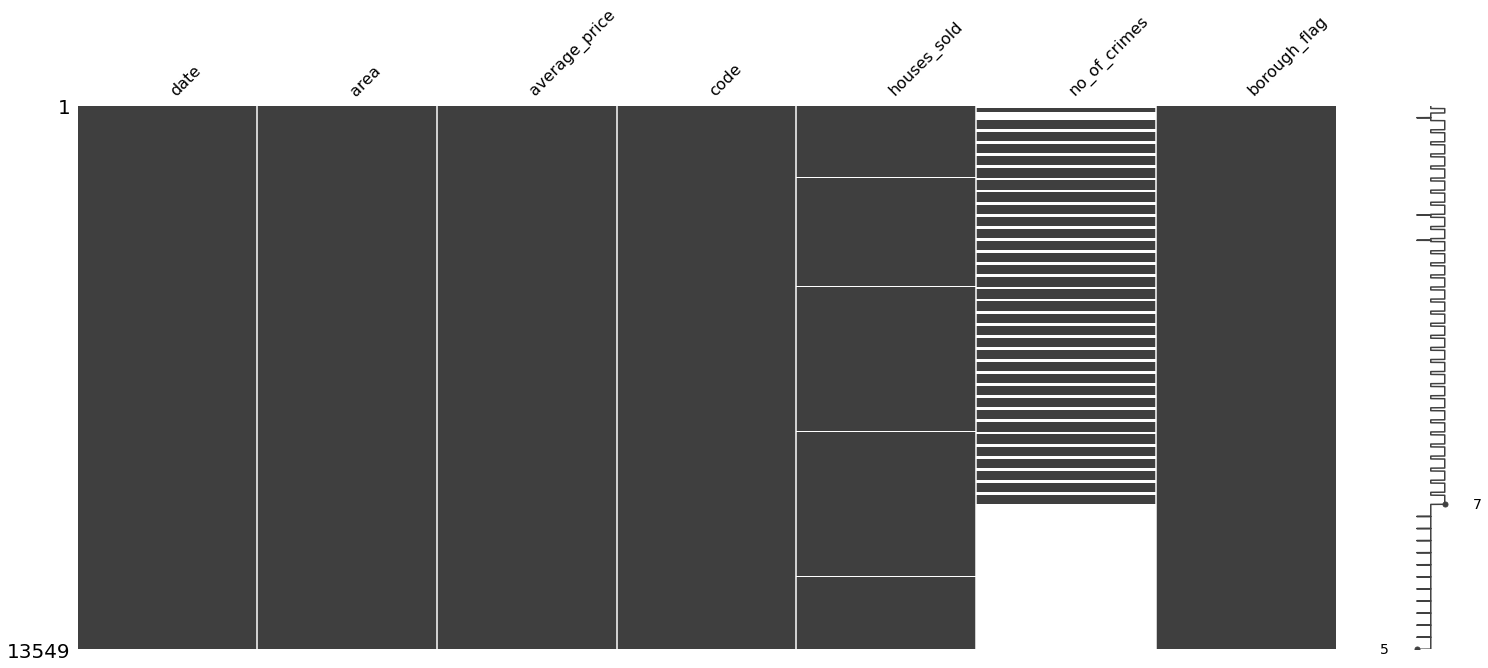

In [3]:
display(df.describe());
msno.matrix(df);

,median_salary,life_satisfaction,population_size,number_of_jobs,area_size,no_of_houses,borough_flag
count,"1,049.00",352.00,"1,018.00",931.00,666.00,666.00,"1,071.00"
mean,"27,977.79",7.49,"6,042,576.49","3,188,094.52","372,490.27","881,468.15",0.65
std,"6,412.81",0.20,"15,268,096.56","8,058,302.24","2,157,060.24","3,690,376.14",0.48
min,"15,684.00",7.00,"6,581.00","47,000.00",315.00,"5,009.00",0.00
25%,"23,857.00",7.35,"224,345.75","94,500.00","2,960.00","87,635.50",0.00
50%,"27,441.00",7.51,"294,603.50","157,000.00","4,323.00","102,402.00",1.00
75%,"30,932.00",7.64,"4,630,098.50","2,217,000.00","8,220.00","126,276.00",1.00
max,"61,636.00",7.96,"66,435,550.00","35,750,000.00","13,303,728.00","24,172,166.00",1.00


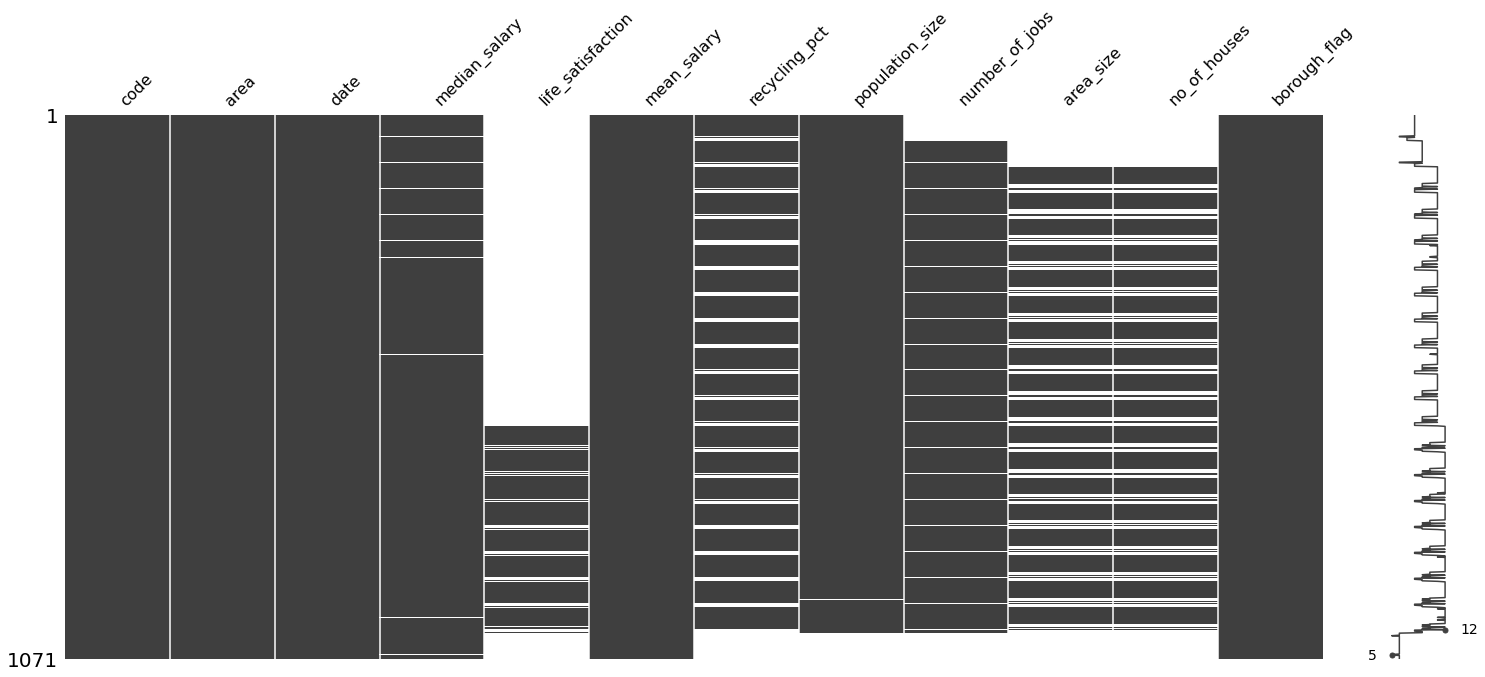

In [4]:
display(df_1.describe())

msno.matrix(df_1);

In [5]:
df = df.set_index(pd.to_datetime(df['date']))
df_1 = df_1.set_index(pd.to_datetime(df_1['date']))

del df['date']
del df_1['date']

df_1['mean_salary'] = df_1['mean_salary'].replace('-', np.NaN)
df_1['mean_salary'] = df_1['mean_salary'].replace('#', np.NaN)
df_1['mean_salary'] = df_1['mean_salary'].astype(float)

prices_london = df[df['borough_flag'] == 1]
prices_england = df[df['area'] == 'england']
prices_north_east = df[df['area'] == 'north east']

london_mean_price = prices_london.groupby('date')['average_price'].mean()
england_mean_price = prices_england.groupby('date')['average_price'].mean()
north_east_mean_price = prices_north_east.groupby('date')['average_price'].mean()

In [6]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=london_mean_price.index, 
                         y=london_mean_price.values,
                         mode='lines',
                         name='London Mean House Price',
                        ))

fig.add_trace(go.Scatter(x=england_mean_price.index, 
                         y=england_mean_price.values,
                         mode='lines',
                         name='England Mean House Price',
                        ))

fig.add_trace(go.Scatter(x=north_east_mean_price.index, 
                         y=north_east_mean_price.values,
                         mode='lines',
                         name='North East Mean House Price',
                        ))


In [7]:
fig.update_layout(
    template='gridon',
    title='Monthly Prices of House (avg)',
    xaxis_title='Year',
    yaxis_title='Price(£)',
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    legend=dict(y=-.2, orientation='h'),
    shapes=[
      dict(
            type="line",
            x0='2020-01-01',
            x1='2020-01-01',
            y0=0,
            y1=london_mean_price.values.max()*1.2,
            line=dict(
            color="LightSalmon",
            dash="dashdot"
            )
        ),        
        dict(
            type="line",
            x0='2016-06-01',
            x1='2016-06-01',
            y0=0,
            y1=london_mean_price.values.max()*1.2,
            line=dict(
            color="LightSalmon",
            dash="dashdot"
            )
        ),
        dict(
            type="rect",
            x0="2007-12-01",
            y0=0,
            x1="2009-06-01",
            y1=london_mean_price.values.max()*1.2,
            fillcolor="LightSalmon",
            opacity=0.5,
            layer="below",
            line_width=0,
        ),
    ],
    annotations=[
            dict(text="COVID-19", x='2020-01-01', y=london_mean_price.values.max()*1.2),
            dict(text="The Great Recession", x='2007-12-01', y=london_mean_price.values.max()*1.2),
            dict(text="Brexit Vote", x='2016-06-01', y=london_mean_price.values.max()*1.2),
    ]
)
fig.show()

In [8]:
fig = px.line(prices_london, x=prices_london.index, y="average_price", color='area')

fig.update_layout(
    template='gridon',
    title='Disturbution of Monthly london House Price by Borough',
    xaxis_title='Year',
    yaxis_title='Price(£)',
    xaxis_showgrid=False,
    yaxis_showgrid=False
)
fig.show()

In [9]:
yearly_prices_london = prices_london.groupby('area').resample('y')['average_price'].mean()


yearly_prices_london_pct_ch = yearly_prices_london.groupby(level='area').apply(lambda x: x.pct_change())

yearly_prices_london_pct_ch = yearly_prices_london_pct_ch.unstack()
yearly_prices_london_pct_ch = yearly_prices_london_pct_ch.iloc[::-1]

del yearly_prices_london_pct_ch['1995-12-31']

In [10]:
fig = go.Figure(data=go.Heatmap(
        z=yearly_prices_london_pct_ch.values,
        x=yearly_prices_london_pct_ch.columns,
        y=yearly_prices_london_pct_ch.index,
        colorscale='darkmint'))

fig.update_layout(
    title='YoY: Change in London House Price Percentage ',
    title_x=0.5,
    yaxis_nticks=33,
    xaxis_title='Year',
    yaxis_title='Borough'
)

fig.show()

In [11]:
london_mean_values = prices_london.groupby('area').resample('y').mean().reset_index()
df_1 = df_1.groupby('area').resample('y').mean().reset_index()
london_mean_values = pd.merge(london_mean_values, df_1, on=['area', 'date'], how='left')

del london_mean_values['borough_flag_x']
del london_mean_values['borough_flag_y']

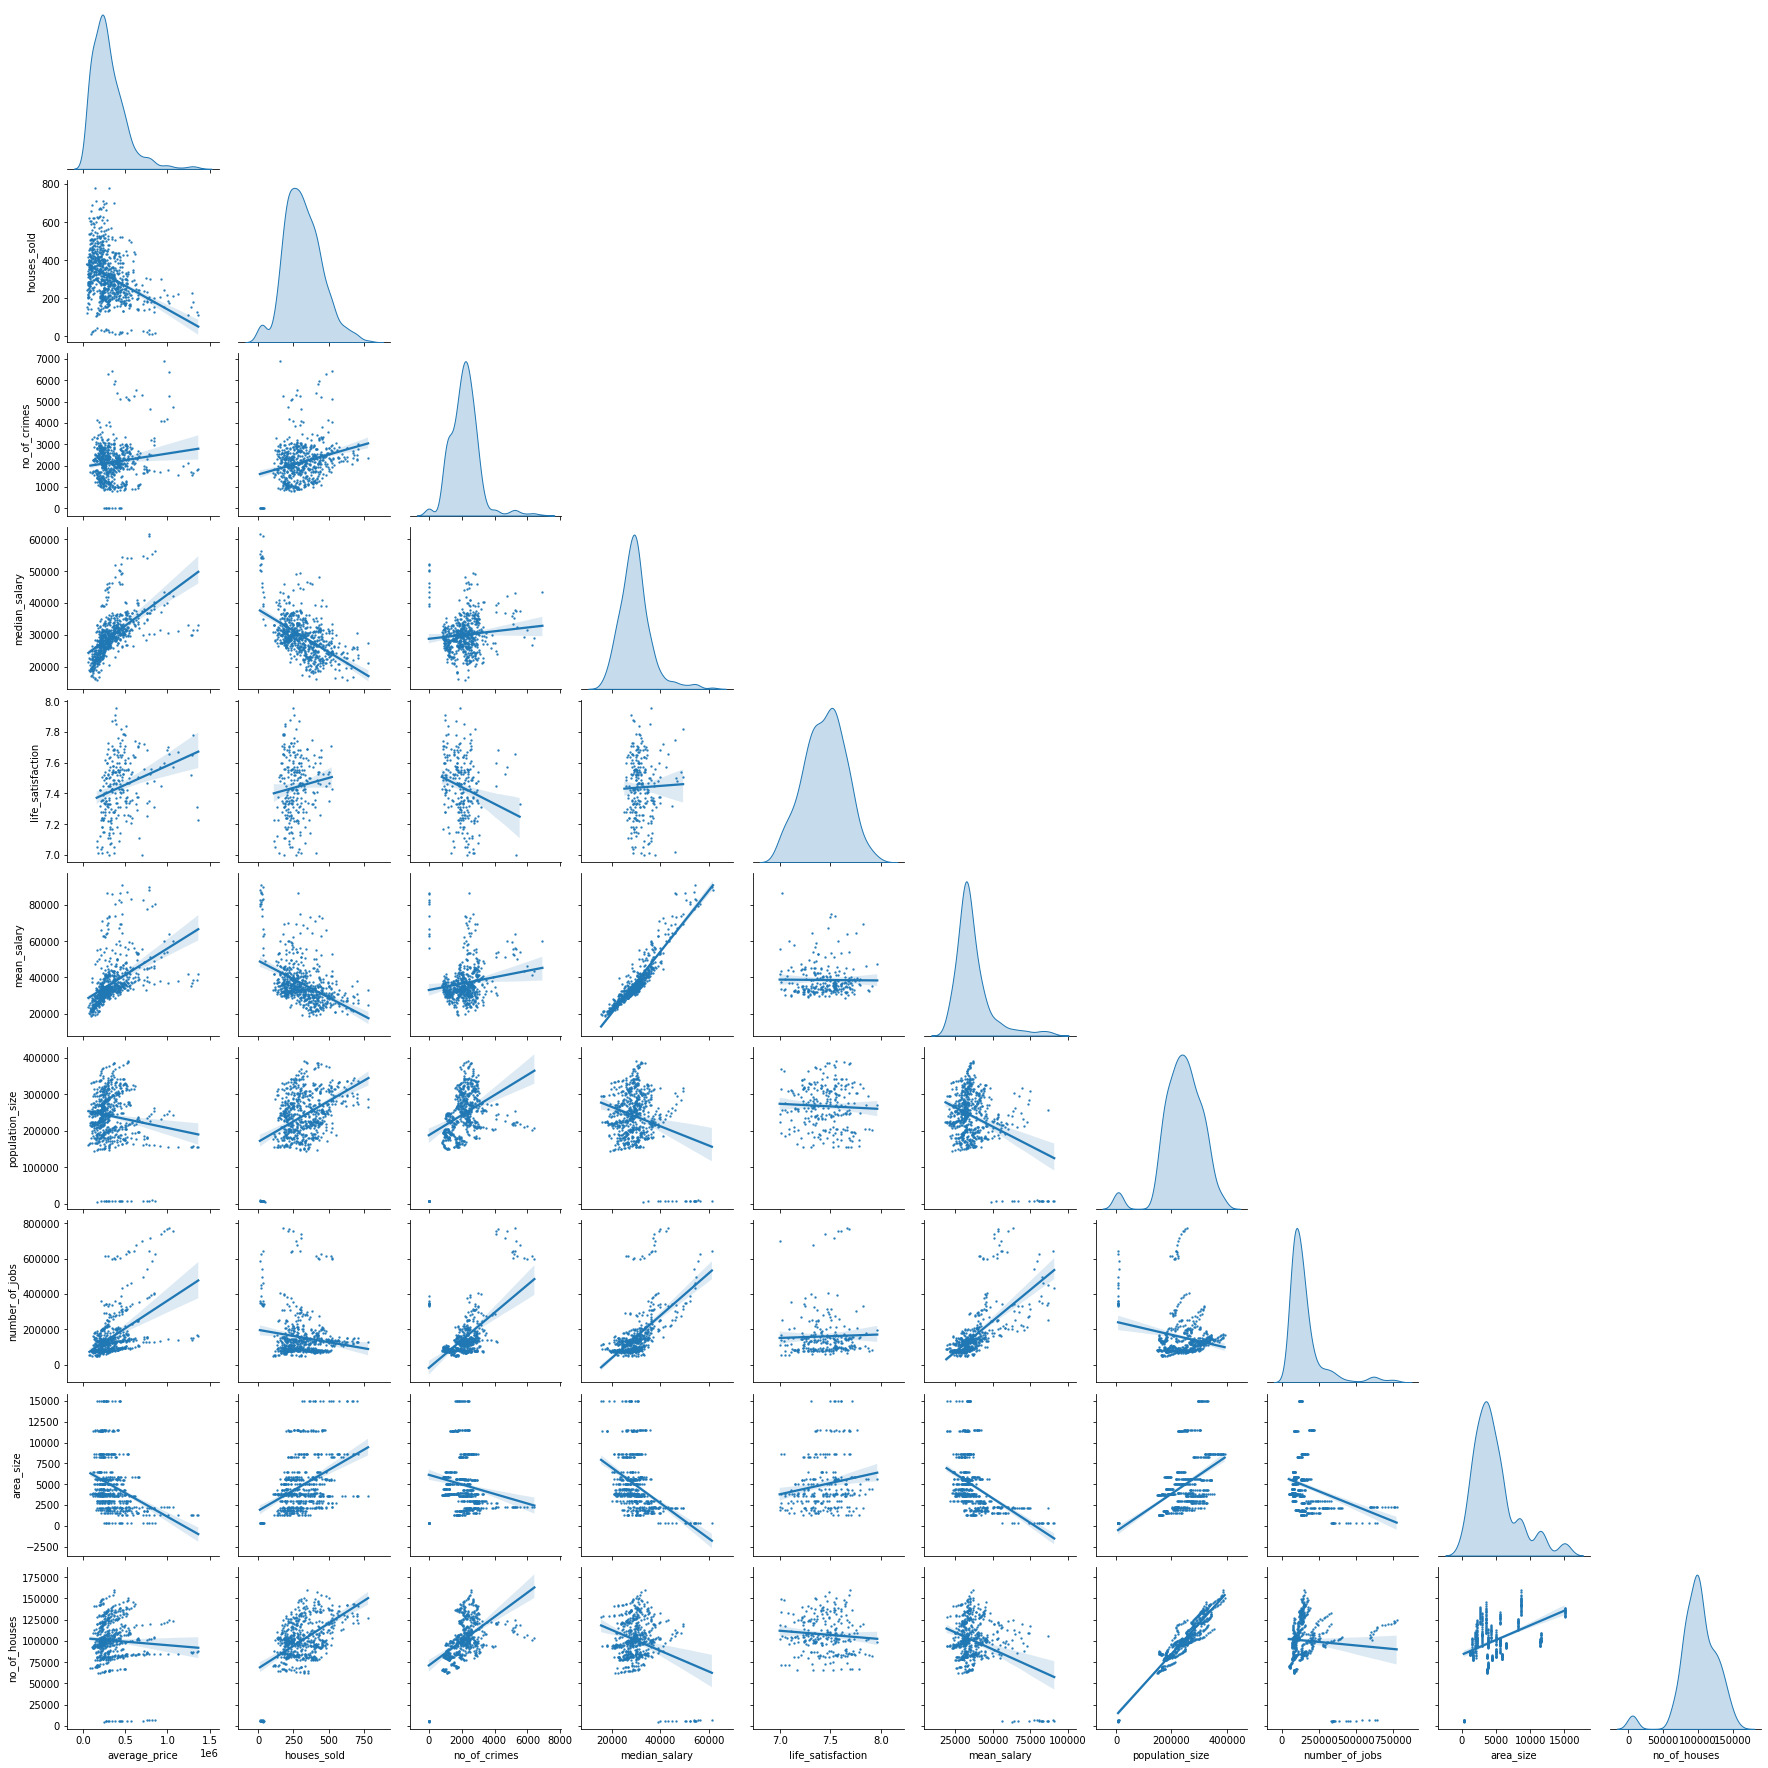

In [12]:
sns.pairplot(london_mean_values, corner=True, kind='reg', diag_kind='kde', plot_kws=dict(scatter_kws=dict(s=2)))
plt.show()

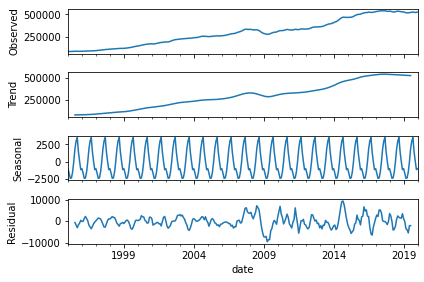

In [13]:
decomposition = sm.tsa.seasonal_decompose(london_mean_price, model='additive')
fig = decomposition.plot()
plt.show()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


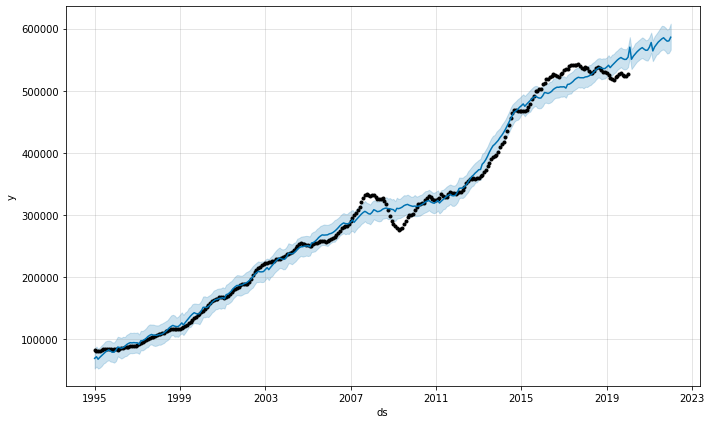

In [14]:
model_df = pd.DataFrame(london_mean_price).reset_index()
model_df = model_df.rename(columns={'date': 'ds', 'average_price': 'y'})


m = Prophet()
m.fit(model_df)

future = m.make_future_dataframe(periods=24, freq='M')

forecast = m.predict(future)


fig1 = m.plot(forecast)

In [15]:
model_df.head()

,ds,y
0,1995-01-01,"81,906.42"
1,1995-02-01,"81,527.97"
2,1995-03-01,"81,349.27"
3,1995-04-01,"81,432.52"
4,1995-05-01,"82,277.30"


In [16]:
from fbprophet.diagnostics import cross_validation

In [26]:
future = m.make_future_dataframe(periods=365, freq= 'D')
forecast = m.predict(future)

In [27]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
661,2020-12-27,"572,048.07","566,490.54","598,766.15","568,780.93","574,947.70","10,380.37","10,380.37","10,380.37","10,380.37","10,380.37","10,380.37",0.00,0.00,0.00,"582,428.45"
662,2020-12-28,"572,090.70","562,403.03","595,557.73","568,810.78","575,000.36","6,500.32","6,500.32","6,500.32","6,500.32","6,500.32","6,500.32",0.00,0.00,0.00,"578,591.01"
663,2020-12-29,"572,133.32","558,438.80","592,247.27","568,840.63","575,053.02","3,055.93","3,055.93","3,055.93","3,055.93","3,055.93","3,055.93",0.00,0.00,0.00,"575,189.25"
664,2020-12-30,"572,175.94","555,608.17","588,878.62","568,866.48","575,110.59",164.83,164.83,164.83,164.83,164.83,164.83,0.00,0.00,0.00,"572,340.77"
665,2020-12-31,"572,218.56","553,784.95","585,723.72","568,885.80","575,176.74","-2,068.92","-2,068.92","-2,068.92","-2,068.92","-2,068.92","-2,068.92",0.00,0.00,0.00,"570,149.64"


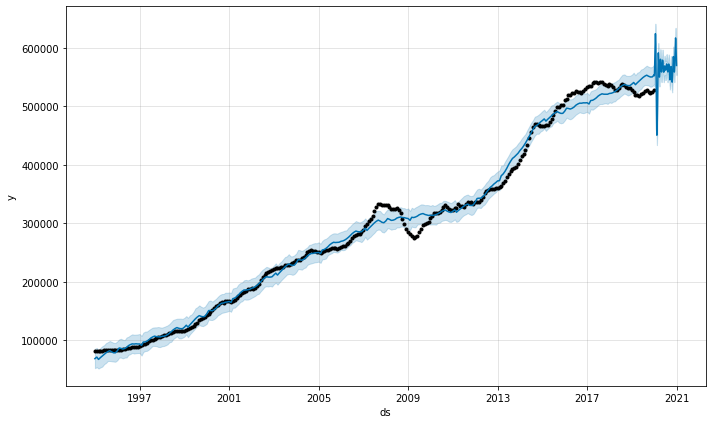

In [19]:
plot2=m.plot(forecast)

In [20]:
model_df.shape

(301, 2)

In [21]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='903 days', period='180 days', horizon = '526 days')

INFO:fbprophet:Making 43 forecasts with cutoffs between 1997-11-11 00:00:00 and 2018-07-24 00:00:00


  0%|          | 0/43 [00:00<?, ?it/s]

In [22]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
739,2019-09-01,"623,273.62","607,177.59","638,802.33","528,443.06",2018-07-24
740,2019-10-01,"623,097.01","607,770.30","638,390.46","525,602.67",2018-07-24
741,2019-11-01,"623,881.48","607,291.13","641,529.88","522,975.88",2018-07-24
742,2019-12-01,"625,846.78","608,305.80","641,947.36","524,032.79",2018-07-24
743,2020-01-01,"631,768.34","613,554.41","648,168.24","527,450.39",2018-07-24


In [23]:
cutoffs = pd.to_datetime(['2019-01-01', '2019-01-01', '2019-01-01'])
df_cv2 = cross_validation(m, cutoffs=cutoffs, horizon='365 days')


  0%|          | 0/3 [00:00<?, ?it/s]

In [24]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,53 days,"448,632,380.02","21,180.94","15,393.79",0.04,0.03,0.04,0.15
1,54 days,"447,105,965.47","21,144.88","15,318.54",0.04,0.03,0.04,0.17
2,56 days,"441,008,194.58","21,000.20","15,115.26",0.04,0.03,0.04,0.17
3,57 days,"435,685,431.29","20,873.08","14,945.94",0.04,0.03,0.04,0.15
4,58 days,"437,537,248.78","20,917.39","15,046.22",0.04,0.03,0.04,0.16
